<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/34_evaluating_finetuned_LLM_using_Ollama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating fine-tuned LLM using Ollama

### Code from previous note

In [1]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = self._format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def _format_input(self, entry):
      instruction_text = (
          f"Below is an instruction that describes a task. "
          f"Write a response that appropriately completes the request."
          f"\n\n### Instruction:\n{entry['instruction']}"
      )

      input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
      return instruction_text + input_text


    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor


Number of entries: 1100
Training set length: 935
Validation set length: 55
Test set length: 110


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

from torch.utils.data import DataLoader

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

num_workers = 0
batch_size = 8

torch.manual_seed(123)
torch.cuda.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    break

Device: cuda
Train loader:
torch.Size([8, 61]) torch.Size([8, 61])


In [3]:
# Model

import requests
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(123)
torch.cuda.manual_seed_all(123)

class GPTModel(nn.Module):
    class LayerNorm(nn.Module):
      def __init__(self, emb_dim):
          super().__init__()
          self.eps = 1e-5
          self.scale = nn.Parameter(torch.ones(emb_dim))
          self.shift = nn.Parameter(torch.zeros(emb_dim))

      def forward(self, x):
          mean = x.mean(dim=-1, keepdim=True)
          var = x.var(dim=-1, keepdim=True, unbiased=False)
          norm_x = (x - mean) / torch.sqrt(var + self.eps)
          return self.scale * norm_x + self.shift

    class GELU(nn.Module):
      def __init__(self) -> None:
        super().__init__()

      def forward(self, x):
        # approx GeLu function
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

    class FeedForward(nn.Module):
      def __init__(self, cfg):
          super().__init__()
          self.layers = nn.Sequential(
              nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
              GPTModel.GELU(),
              nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
          )

      def forward(self, x):
          return self.layers(x)

    class MultiHeadAttention(nn.Module):
      def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
          super().__init__()
          assert (d_out % num_heads == 0), \
              "d_out must be divisible by num_heads"

          self.d_out = d_out
          self.num_heads = num_heads
          self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

          self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
          self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
          self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
          self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
          self.dropout = nn.Dropout(dropout)
          self.register_buffer(
              "mask",
              torch.triu(torch.ones(context_length, context_length),
                        diagonal=1)
          )

      def forward(self, x):
          b, num_tokens, d_in = x.shape

          keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
          queries = self.W_query(x)
          values = self.W_value(x)

          # We implicitly split the matrix by adding a `num_heads` dimension
          # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
          keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
          values = values.view(b, num_tokens, self.num_heads, self.head_dim)
          queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

          # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
          keys = keys.transpose(1, 2)
          queries = queries.transpose(1, 2)
          values = values.transpose(1, 2)

          # Compute scaled dot-product attention (aka self-attention) with a causal mask
          attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

          # Original mask truncated to the number of tokens and converted to boolean
          mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

          # Use the mask to fill attention scores
          attn_scores.masked_fill_(mask_bool, -torch.inf)

          attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
          attn_weights = self.dropout(  attn_weights)

          # Shape: (b, num_tokens, num_heads, head_dim)
          context_vec = (attn_weights @ values).transpose(1, 2)

          # Combine heads, where self.d_out = self.num_heads * self.head_dim
          context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
          context_vec = self.out_proj(context_vec) # optional projection

          return context_vec

    class TransformerBlock(nn.Module):
        def __init__(self, cfg):
            super().__init__()
            self.att = GPTModel.MultiHeadAttention(
                d_in=cfg["emb_dim"],
                d_out=cfg["emb_dim"],
                context_length=cfg["context_length"],
                num_heads=cfg["n_heads"],
                dropout=cfg["drop_rate"],
                qkv_bias=cfg["qkv_bias"])
            self.ff = GPTModel.FeedForward(cfg)
            self.norm1 = GPTModel.LayerNorm(cfg["emb_dim"])
            self.norm2 = GPTModel.LayerNorm(cfg["emb_dim"])
            self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

        def forward(self, x):
            # Shortcut connection for attention block
            shortcut = x
            x = self.norm1(x)
            x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
            x = self.drop_shortcut(x)
            x = x + shortcut  # Add the original input back

            # Shortcut connection for feed forward block
            shortcut = x
            x = self.norm2(x)
            x = self.ff(x)
            x = self.drop_shortcut(x)
            x = x + shortcut  # Add the original input back

            return x

    # GPTModel itself
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[GPTModel.TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = GPTModel.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds

        # dropout helps in generalization and avoid overfitting
        x = self.drop_emb(x)
        x = self.trf_blocks(x)

        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx



In [4]:
class TokenUtils:
  @staticmethod
  def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

  @staticmethod
  def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


In [5]:
import os
import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import numpy as np


class GPT2Weightloader:

  @staticmethod
  def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        GPT2Weightloader.download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = GPT2Weightloader.load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

  @staticmethod
  def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        response = requests.get(download_url, stream=True, timeout=60)
        response.raise_for_status()

        file_size = int(response.headers.get("Content-Length", 0))

        # Check if file exists and has same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size and file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return True

        block_size = 1024  # 1 KB
        desc = os.path.basename(download_url)
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=desc) as progress_bar:
            with open(destination, "wb") as file:
                for chunk in response.iter_content(chunk_size=block_size):
                    if chunk:
                        file.write(chunk)
                        progress_bar.update(len(chunk))
        return True

    try:
        if _attempt_download(url):
            return
    except requests.exceptions.RequestException:
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except requests.exceptions.RequestException:
                pass

        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

  # Alternative way using `requests`
  """
  def download_file(url, destination):
      # Send a GET request to download the file in streaming mode
      response = requests.get(url, stream=True)

      # Get the total file size from headers, defaulting to 0 if not present
      file_size = int(response.headers.get("content-length", 0))

      # Check if file exists and has the same size
      if os.path.exists(destination):
          file_size_local = os.path.getsize(destination)
          if file_size == file_size_local:
              print(f"File already exists and is up-to-date: {destination}")
              return

      # Define the block size for reading the file
      block_size = 1024  # 1 Kilobyte

      # Initialize the progress bar with total file size
      progress_bar_description = url.split("/")[-1]  # Extract filename from URL
      with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
          # Open the destination file in binary write mode
          with open(destination, "wb") as file:
              # Iterate over the file data in chunks
              for chunk in response.iter_content(block_size):
                  progress_bar.update(len(chunk))  # Update progress bar
                  file.write(chunk)  # Write the chunk to the file
  """

  @staticmethod
  def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

  @staticmethod
  def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

  @staticmethod
  def load_weights_into_gpt(gpt, params):
      gpt.pos_emb.weight = GPT2Weightloader.assign(gpt.pos_emb.weight, params['wpe'])
      gpt.tok_emb.weight = GPT2Weightloader.assign(gpt.tok_emb.weight, params['wte'])

      for b in range(len(params["blocks"])):
          q_w, k_w, v_w = np.split(
              (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
          gpt.trf_blocks[b].att.W_query.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_query.weight, q_w.T)
          gpt.trf_blocks[b].att.W_key.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_key.weight, k_w.T)
          gpt.trf_blocks[b].att.W_value.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_value.weight, v_w.T)

          q_b, k_b, v_b = np.split(
              (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
          gpt.trf_blocks[b].att.W_query.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_query.bias, q_b)
          gpt.trf_blocks[b].att.W_key.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_key.bias, k_b)
          gpt.trf_blocks[b].att.W_value.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_value.bias, v_b)

          gpt.trf_blocks[b].att.out_proj.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.out_proj.weight,
              params["blocks"][b]["attn"]["c_proj"]["w"].T)
          gpt.trf_blocks[b].att.out_proj.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.out_proj.bias,
              params["blocks"][b]["attn"]["c_proj"]["b"])

          gpt.trf_blocks[b].ff.layers[0].weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[0].weight,
              params["blocks"][b]["mlp"]["c_fc"]["w"].T)
          gpt.trf_blocks[b].ff.layers[0].bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[0].bias,
              params["blocks"][b]["mlp"]["c_fc"]["b"])
          gpt.trf_blocks[b].ff.layers[2].weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[2].weight,
              params["blocks"][b]["mlp"]["c_proj"]["w"].T)
          gpt.trf_blocks[b].ff.layers[2].bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[2].bias,
              params["blocks"][b]["mlp"]["c_proj"]["b"])

          gpt.trf_blocks[b].norm1.scale = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm1.scale,
              params["blocks"][b]["ln_1"]["g"])
          gpt.trf_blocks[b].norm1.shift = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm1.shift,
              params["blocks"][b]["ln_1"]["b"])
          gpt.trf_blocks[b].norm2.scale = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm2.scale,
              params["blocks"][b]["ln_2"]["g"])
          gpt.trf_blocks[b].norm2.shift = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm2.shift,
              params["blocks"][b]["ln_2"]["b"])

      gpt.final_norm.scale = GPT2Weightloader.assign(gpt.final_norm.scale, params["g"])
      gpt.final_norm.shift = GPT2Weightloader.assign(gpt.final_norm.shift, params["b"])
      gpt.out_head.weight = GPT2Weightloader.assign(gpt.out_head.weight, params["wte"])


In [10]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = GPT2Weightloader.download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
GPT2Weightloader.load_weights_into_gpt(model, params)
model.to(device) # Add this line to move the model to the correct device
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [11]:
def format_input(entry):
      instruction_text = (
          f"Below is an instruction that describes a task. "
          f"Write a response that appropriately completes the request."
          f"\n\n### Instruction:\n{entry['instruction']}"
      )

      input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
      return instruction_text + input_text


In [12]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_text_simple(model, idx, max_new_tokens, context_size):

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = TokenUtils.text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = TokenUtils.token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [13]:
import time
import torch

start_time = time.time()

torch.manual_seed(123)
torch.cuda.manual_seed(123)


optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.533, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.563, Val loss

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

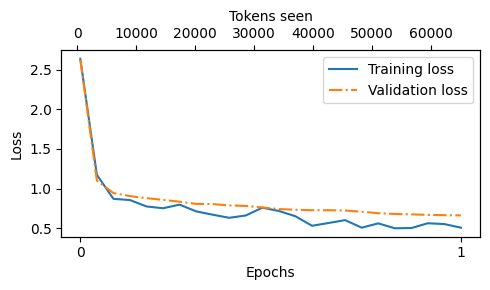

In [15]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## How to measure performance?

On previous note -  \
Desired respoonse: "The meal is cooked by the chef every day"
LLM response: "The meal is prepared by the chef every day".

How to quantify the performance of LLM.

**Stage 3:**
1. Extracting responses
2. Qualitative evaluation
3. Scoring the responses

Generate results for 3 test set samples

In [16]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx= TokenUtils.text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = TokenUtils.token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cloud that typically forms in the atmosphere over a region of high pressure. It typically produces a strong wind that blows across the area, creating a dense, dense cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruc

As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well.

The answers to the first instruction is clearly correct, while the second answer and the third answers are not correct.

This is because we have done the fine-tuning for only 1 epoch due to hardware limitations. To get better results, we need to increase the epochs to at least 2.

Most importantly, we can see that model evaluation is not as straightforward as in the previous notes, where we simply calculated the percentage of correct spam/non-spam class labels to obtain the classification accuracy.

In practice, instruction-finetuned LLMs
such as chatbots are evaluated via multiple approaches:

1. Short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding," https://arxiv.org/abs/2009.
03300), which test the general knowledge of a model.

2. Human preference comparison to other LLMs, such as LMSYS chatbot
arena (https://arena.lmsys.org).

3. Automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval (https://tatsulab.github.io/alpaca_eval/).
completes the request.

we will implement an approach similar to method 3, which involves evaluating the responses automatically using another LLM.

This will allow us to efficiently assess the quality of the generated responses without the need for extensive human involvement, thereby saving time and resources while still obtaining
meaningful performance indicators.

### Generate result for entire test set

In [17]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=TokenUtils.text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = TokenUtils.token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:29<00:00,  1.23it/s]


In [18]:
# verifying the test data result.
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


Save model for future usecase.

In [19]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


### Evaluating the finetuned LLM

We implement a method to automate the response evaluation of the finetuned LLM using another, larger LLM.

To implement the evaluation step which involves evaluating test set responses in an automated fashion, we utilize an existing instruction-finetuned 8 billion parameter Llama
3 model developed by Meta AI.

This model can be run locally using the open-source Ollama
application (https://ollama.com).

Ollama is an efficient application for running LLMs on a laptop.

It serves as a wrapper around the open-source llama.cpp library (https://github.com/ggerganov/llama.cpp), which
implements LLMs in pure C/C++ to maximize efficiency.

However, note that Ollama is only a tool for generating text using LLMs (inference) and does not support training or finetuning
LLMs.

The following code verifies that the Ollama session is running properly before we use Ollama to evaluate the test set responses generated previously:

In [24]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

RuntimeError: Ollama not running. Launch ollama before proceeding.

An alternative to the ollama run command for interacting with the model is through its REST API using Python.

Use ngrok to connect via api.

In [26]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url= "<Ngrok url>" + "/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

In [27]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

Using the query_model function defined earlier, we can evaluate the responses generated by our finetuned model with a prompt that prompts the Llama 3 model to rate our finetuned model's responses on a scale from 0 to 100 based on the given test set response
as reference.

In [ ]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

Llama 3 model provides reasonable evaluations and is capable of assigning partial points when a model's answer is not entirely correct.

The previous prompt returns highly detailed evaluations in addition to the score.

We can modify the prompt to just generate integer scores ranging from 0 to 100, where 100 represents the best possible score.

This modification allows us to calculate an average score
for our model, which serves as a more concise and quantitative assessment of its performance.

In [ ]:
for entry in test_data[:2]:
    prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
    score = query_model(prompt, model)
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt, model))
    print("\n-------------------------")


Dataset response:
The car is as fast as lightning.

Model response:
The car is as fast as a bullet.

Score: 85


We can use below function to generate score of our output using json data.

In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

When you run the above code, the evaluation output shows that our finetuned model achieves an average score above 50,
which provides a useful benchmark for comparison against other models or for experimenting with different training configurations to improve the model's performance.

It's worth noting that Ollama is not entirely deterministic at the time of this writing, which means that the scores you obtain might slightly vary from the ones presented above.
    
To obtain more robust results, you can repeat the evaluation multiple times and average the resulting scores.

To further improve our model's performance, we can explore various strategies, such as:

(1) Adjusting the hyperparameters during finetuning, such as the learning rate, batch size, or number of epochs.


(2) Increasing the size of the training dataset or diversifying the examples to cover a broader range of topics and styles.


(3) Experimenting with different prompts or instruction formats to guide the model's responses more effectively.


(4) Considering the use of a larger pretrained model, which may have greater capacity to capture complex patterns and generate more accurate responses.

(5) We can also use parameter efficient fine-tuning techniques like LoRA.